# Crime/Frequency Across Dallas County 




###### Ellen Hu, Benjamin Podell, Valentina Delia, David Liska, & Haley Holcomb 

---------------------------------------------------------
## Introductions: 

Our group pulled in data from "Police Incidents" Report off of Dallas open data at "www.dallasopendata.com" with the following questions in mind: 



    What different area of Dallas have the highest crime rates, and how does it affect development? 

    What types of crime are more prevalent within Dallas? 

    How does time of day, day of the week and month of the year affect the frequency of crime?








In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#import dependencies 

import requests
import json
import numpy as np
import gmaps
from config import(gkey)
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from datetime import datetime
from dateutil.parser import parse


In [27]:
# pulling CSV file
police = "Resources/police_data.csv"
police_df = pd.read_csv(police, encoding="ISO-8859-1")
#Preview of the data 
police_df.head()

,Incident Number w/year,Year of Incident,Watch,Call (911) Problem,Type of Incident,Date1 of Occurrence,Month1 of Occurence,Day1 of the Week,Time1 of Occurrence,Call Dispatch Date Time,X Coordinate,Y Cordinate,Zip Code,City,State
0,038164-2018,2018,3,6XEA - DISTURBANCE EMERG AMB,RESIST ARREST SEARCH OR TRANSPORT,2/21/2018,February,Wed,19:30,2/21/2018 19:41,NaN,NaN,NaN,NaN,NaN
1,066284-2018,2018,1,6X - MAJOR DIST (VIOLENCE),ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),3/30/2018,March,Fri,01:40,3/30/2018 01:27,NaN,NaN,NaN,NaN,NaN
2,086521-2018,2018,3,15A - ASSIST OFFICER W/AMB,ASSAULT (AGG) -DEADLY WEAPON,4/24/2018,April,Tue,16:12,4/24/2018 16:12,NaN,NaN,NaN,NaN,NaN
3,038164-2018,2018,3,6XEA - DISTURBANCE EMERG AMB,ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),2/21/2018,February,Wed,19:30,2/21/2018 19:41,NaN,NaN,NaN,NaN,NaN
4,060055-2018,2018,1,40/01 - OTHER,ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),3/22/2018,March,Thu,04:45,3/22/2018 04:48,NaN,NaN,NaN,NaN,NaN


In [28]:
#Getting a total count of each column
police_df.count()

Incident Number w/year     133949
Year of Incident           133949
Watch                      133949
Call (911) Problem         132683
Type of Incident           133949
Date1 of Occurrence        133949
Month1 of Occurence        133949
Day1 of the Week           133949
Time1 of Occurrence        133949
Call Dispatch Date Time    132673
X Coordinate                98503
Y Cordinate                 98503
Zip Code                   133669
City                       132123
State                      132974
dtype: int64

In [29]:
#Cleaning data by dropping NaN values for a complete data set in order to have consitent infromation accross the board
police_df = police_df.dropna(how='any')

#Getting the new total count of each column
police_df.count()

Incident Number w/year     95440
Year of Incident           95440
Watch                      95440
Call (911) Problem         95440
Type of Incident           95440
Date1 of Occurrence        95440
Month1 of Occurence        95440
Day1 of the Week           95440
Time1 of Occurrence        95440
Call Dispatch Date Time    95440
X Coordinate               95440
Y Cordinate                95440
Zip Code                   95440
City                       95440
State                      95440
dtype: int64

In [30]:
#Preview of cleaned df
police_df.head()

,Incident Number w/year,Year of Incident,Watch,Call (911) Problem,Type of Incident,Date1 of Occurrence,Month1 of Occurence,Day1 of the Week,Time1 of Occurrence,Call Dispatch Date Time,X Coordinate,Y Cordinate,Zip Code,City,State
205,171565-2018,2018,3,40 - OTHER,VIO PROTECT ORDER BIAS/PREJUDICE,8/4/2018,August,Sat,21:54,8/4/2018 23:30,2476498.585,6971715.153,75212.0,DALLAS,TX
212,257226-2018,2018,2,58 - ROUTINE INVESTIGATION,ABANDONED PROPERTY (NO OFFENSE),11/26/2018,November,Mon,15:20,11/30/2018 08:53,2548241.858,6932130.126,75253.0,DALLAS,TX
219,249258-2018,2018,1,7X - MAJOR ACCIDENT,PUBLIC INTOXICATION,11/18/2018,November,Sun,00:25,11/18/2018 00:39,2525365.155,6960102.895,75217.0,DALLAS,TX
221,279186-2018,2018,2,16 - INJURED PERSON,ASSAULT -BODILY INJURY ONLY,12/31/2018,December,Mon,14:00,12/31/2018 15:20,2496126.907,6941940.628,75216.0,DALLAS,TX
222,209518-2018,2018,2,55 - TRAFFIC STOP,WARRANT-DALLAS PD (ALIAS/CAPIAS),9/21/2018,September,Fri,08:48,9/21/2018 08:48,2487800.730,6937829.316,75216.0,DALLAS,TX


# What different area of Dallas have the highest crime rates, and how does it affect development? 


In [31]:
dallas_crimes_per_zip = pd.DataFrame({
    "Dallas District": ["Uptown", 
                        "Dallas Design District", 
                        "Baylor", 
                        "Dallas Arts District", 
                        "West Dallas", 
                        "Oak Cliff",
                        "Dallas Design District",
                        "River Front",
                        "East Dallas",
                        "South Side",
                        "Cedars",
                        "Deep Ellum",
                        "South Fair Park",
                        "Highland Park",
                        "Cedar Crest"],
    "Zip Code": [75201, 75202, 75207, 75246, 75204, 75212, 75203, 75208, 75256, 75210, 75215, 75226, 75223, 75205, 75216],
    "Total Reported Crimes 2018": [3102, 1837, 1045, 275, 3091, 2139, 1717, 1996, 275, 1710, 4131, 2474, 1037, 224, 5683]
})

dcp = dallas_crimes_per_zip.sort_values('Total Reported Crimes 2018' , ascending = False)
dcp

,Dallas District,Zip Code,Total Reported Crimes 2018
14,Cedar Crest,75216,5683
10,Cedars,75215,4131
0,Uptown,75201,3102
4,West Dallas,75204,3091
11,Deep Ellum,75226,2474
5,Oak Cliff,75212,2139
7,River Front,75208,1996
1,Dallas Design District,75202,1837
6,Dallas Design District,75203,1717
9,South Side,75210,1710


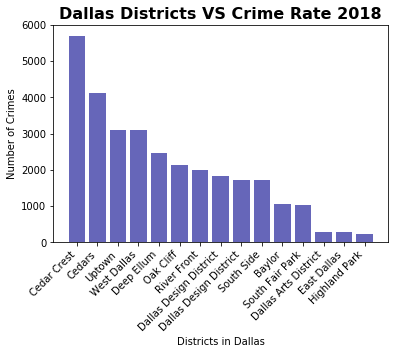

In [32]:
%matplotlib inline
# Bar Graph Test [Is Not Final Visual] [Just want to see what data looks like]
zipcodes = dcp["Dallas District"]
crimes = dcp["Total Reported Crimes 2018"]
x_axis = np.arange(len(crimes))
plt.bar(x_axis, crimes, color="b", align="center",alpha=0.6,facecolor='darkblue' )

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, zipcodes, rotation=45, ha = 'right')
plt.ylim(0, 6000)
plt.title("Dallas Districts VS Crime Rate 2018",fontsize=16, fontweight='bold')
plt.xlabel("Districts in Dallas")
plt.ylabel("Number of Crimes")
plt.show()

In [33]:
#Getting the Lat and Long Values
txzips = "Resources/txzipslatlong.csv"
zip_lat_long_data = pd.read_csv(txzips, encoding="utf-8")

#Merge and preview the data
incidents_zip_lat_long_df= pd.merge(dallas_crimes_per_zip,zip_lat_long_data, how='left', left_on=['Zip Code'], right_on=['zip'])
incidents_zip_lat_long_df.head()

,Dallas District,Zip Code,Total Reported Crimes 2018,zip,lat,lng
0,Uptown,75201,3102,75201.0,32.78780,-96.79948
1,Dallas Design District,75202,1837,75202.0,32.77924,-96.80472
2,Baylor,75207,1045,75207.0,32.78676,-96.82139
3,Dallas Arts District,75246,275,75246.0,32.79292,-96.77330
4,West Dallas,75204,3091,75204.0,32.80205,-96.78882


In [34]:
#Drop NaN values to clean df for mapping lat and long
incidents_zip_lat_long_df = incidents_zip_lat_long_df.dropna(how='any')
incidents_zip_lat_long_df.head()

,Dallas District,Zip Code,Total Reported Crimes 2018,zip,lat,lng
0,Uptown,75201,3102,75201.0,32.78780,-96.79948
1,Dallas Design District,75202,1837,75202.0,32.77924,-96.80472
2,Baylor,75207,1045,75207.0,32.78676,-96.82139
3,Dallas Arts District,75246,275,75246.0,32.79292,-96.77330
4,West Dallas,75204,3091,75204.0,32.80205,-96.78882


In [52]:
#Heat map 
gmaps.configure(api_key=gkey)

locations = incidents_zip_lat_long_df[["lat", "lng"]].astype(float)
crime_rate = incidents_zip_lat_long_df["Total Reported Crimes 2018"].astype(float)
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=crime_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = .005)

heat_layer.dissipating = False
heat_layer.max_intensity = 100
heat_layer.point_radius = .005
#heat_layer.zoom = -1

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

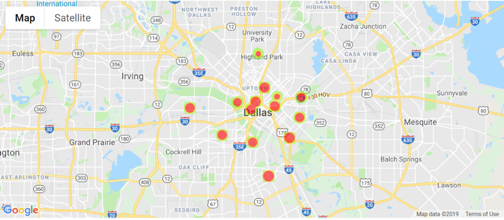

# Analysis of Figure 1. 

Analysis: To look at the prevalence of the crimes at major business areas and advise how patrol resources should be distributed throughout the area, we look at different zip codes representing 15 major business areas. Highest prevalent area is at Cedar Crest and has as many as 5,683 incidents during the year. Lowest prevalent area is Highland Park, which has about one twentieth as many as at Cedar Crest.

We calculated the crime rates using these zip codes and visualized using a heat map on Google Map. We see that each major business district has fairly comparable crime prevalence regardless of which part of Dallas County it is in. Crime heat spots are more concentrated in the Central Dallas area since this area’s zip codes are smaller. The tightly-packed, similarly sized spots there represent a denser incident area. Highland park area is known for low crime rate, and it is one of the two spots that has a smaller heat area. The other low prevalent zip codes belong to the Dallas Arts District and East Dallas.
Further study can include extending the heat map visualization to all zip codes rather than focuses on just major business areas.

# What types of crime are more prevalent in Dallas? 

In [36]:
#pulling the type of "crime" that is being called in and the count to the type of crime 
#police_df['Call (911) Problem'].value_counts()
police_df['Call (911) Problem'] = police_df['Call (911) Problem'].replace(
    {'09 - THEFT': 'THEFT',
    '09/01 - THEFT' : 'THEFT',
    'PSE/09 - THEFT': 'THEFT', 
    '20 - ROBBERY' : 'ROBBERY', 
    '20R - ROBBERY (REPORT)+1HR': 'ROBBERY',
    '12B - BUSINESS ALARM' : 'ALARMS_DISTURBANCE',
    '12N - BURGLAR ALARM NONDISP': 'ALARMS_DISTURBANCE', 
    '12R - RESIDENTIAL ALARM': 'ALARMS_DISTURBANCE',
    '21R - RES PANIC  ALARM': 'ALARMS_DISTURBANCE', 
    '6XE - DISTURBANCE EMERGENCY': 'ALARMS_DISTURBANCE',
    'ARSON -ALL OTHERS': 'ALARMS_DISTURBANCE', 
    '6XA - MAJOR DIST  AMBULANCE': 'ALARMS_DISTURBANCE',
    '6XEA - DISTURBANCE EMERG AMB': 'ALARMS_DISTURBANCE', 
    '6M - LOUD MUSIC DISTURBANCE': 'ALARMS_DISTURBANCE',
    "6X/01 WOMEN'S SHELTER DIST": 'ALARMS_DISTURBANCE',
    '22 - ANIMAL DISTURBANCE' : 'ALARMS_DISTURBANCE',
    '12 - BURGLAR ALARM UNKNOWN' : 'ALARMS_DISTURBANCE',
    '15 - ASSIST OFFICER': 'ASSISTING_OFFICER', 
    '15A - ASSIST OFFICER W/AMB': 'ASSISTING_OFFICER',
    '14 - STABBING, CUTTING': 'INJURY', 
    '16 - INJURED PERSON': 'INJURY',
    '16A - INJURED PERSON W/AMB': 'INJURY', 
    '11B - BURG OF BUS' : 'BURGLARY',
    '11B/01 - BURG OF BUS': 'BURGLARY',
    '11C - BURG COIN OPER' : 'BURGLARY',
    '11C/01 - BURG COIN OPER' : 'BURGLARY',
    '11R - BURG OF RES' : 'BURGLARY',
    '11R/01 - BURG OF RES' : 'BURGLARY',
    '11V - BURG MOTOR VEH' : 'BURGLARY',
    '11V/01 - BURG MOTOR VEH' : 'BURGLARY',
    'PSE/11B - BURG OF BUS' : 'BURGLARY',
    'PSE/11C -  BURG COIN OP' : 'BURGLARY',
    'PSE/11R - BURG OF RES' : 'BURGLARY',
    'PSE/11V - BURG MOTOR VEH' : 'BURGLARY',
    '18 - STRUCTURE FIRE' : 'FIRE',
    '18A - VEHICLE FIRE' : 'FIRE',
    '**PD REQUESTED BY FIRE' : 'FIRE',
    'SIP - SLEEPING IN PUBLIC' : 'MINOR_OFFENSES',
    '06 - MINOR DISTURBANCE' : 'MINOR_OFFENSES',
    'PH - PANHANDLER' : 'MINOR_OFFENSES',
    'PSE/11R - BURG OF RES' : 'BURGLARY',
    'PSE/11V - BURG MOTOR VEH' : 'BURGLARY',
    'TOW - TOWREPO' : 'VEHICLE_VIOLATIONS',
    '23 - PARKING VIOLATION' : 'VEHICLE_VIOLATIONS',
    'PK - PARK CHECK' : 'VEHICLE_VIOLATIONS',
    '55 - TRAFFIC STOP' : 'VEHICLE_VIOLATIONS',
    'BCA - BAIT CAR ACTIVATION' : 'VEHICLE_VIOLATIONS',
    '09V - UUMV' : 'VEHICLE_VIOLATIONS',
    '09V-01 UUMV JUST OCRD' : 'VEHICLE_VIOLATIONS',
    '43 - ROAD RAGE' : 'VEHICLE_VIOLATIONS',
    '37 - STREET BLOCKAGE' : 'VEHICLE_VIOLATIONS',
    '37F - FREEWAY BLOCKAGE' : 'VEHICLE_VIOLATIONS',
    '39 - SPEEDING/RACING' : 'VEHICLE_VIOLATIONS',
    'PSE/09V - UUMV' : 'VEHICLE_VIOLATIONS',
    'DH - DRUG HOUSE' : 'DRUG_RELATED',
    'OADS - OPEN AIR DRUG SALES' : 'DRUG_RELATED',
    'DAEF-DIST ARMED ENCOUNTER FOOT' : 'ARMED_OFFENSE',
    'DAEV-DIST ARMED ENCOUNTER VEH' : 'ARMED_OFFENSE',
    'DASF-DIST ACTIVE SHOOTER FOOT' : 'ARMED_OFFENSE',
    'DASV-DIST ACTIVE SHOOTER VEH' : 'ARMED_OFFENSE',
    '6G - RANDOM GUN FIRE' : 'ARMED_OFFENSE',
    '19 - SHOOTING' : 'ARMED_OFFENSE',
    '21B - BUSINESS HOLD UP' : 'ARMED_OFFENSE',
    '28 - OPEN CARRY' : 'ARMED_OFFENSE',
    'AC - ANIMAL CRUELTY' : 'ANIMAL_CRUELTY',
    'AC/01 - ANIMAL CRUELTY IN PROG' : 'ANIMAL_CRUELTY',    
    '22A - ANIMAL ATTACK' : 'ANIMAL_CRUELTY',
    '41/09 - THEFT - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/09V  - UUMV IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11B - BURG BUSN IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11R - BURG RES IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/11V - BMV-IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/20 - ROBBERY - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '41/25 - CRIMINAL ASLT -IN PROG' : 'CRIME_IN_PROGRESS',
    '41/31 - CRIM MIS/PROGRESS/FELO' : 'CRIME_IN_PROGRESS',
    '41/40 - OTHER - IN PROGRESS' : 'CRIME_IN_PROGRESS',
    '25 - CRIMINAL ASSAULT' : 'CRIME_IN_PROGRESS',
    '42 - CHASE' : 'POLICE_CHASE',
    '42FP - FOOT PURSUIT' : 'POLICE_CHASE',
    '31/01 - CRIM MIS/PROG/NON FELO' : 'CRIMINAL_MISCONDUCT',
    '30 - PRISONER' : 'OTHER',
    '30/01 - ODO W/PRISONER' : 'OTHER',
    '30D - PRISONER OTHER AGENCY' : 'OTHER',
    '36/01 - ABAND CHILD CRITICAL' : 'ABANDONMENT',
    '24 - ABANDONED PROPERTY' : 'ABANDONMENT',
    '29 - OPEN BUILDING' : 'ABANDONMENT',
    '33 - PROSTITUTION' : 'PROSTITUTION',
    'PSE/40 - OTHER' : 'OTHER',
    'WIC - WALK IN CASE' : 'OTHER',
    '04 - 911 HANG UP' : 'OTHER',
    'ODJ - OFF DUTY JOB' : 'OTHER',
    '40 - OTHER' : 'OTHER',
    'WIC - WALK IN CASE #' : 'OTHER',
    '40/01 - OTHER' : 'OTHER',
    '76 - WARRANT SERVICE' : 'OTHER',
    'PSE/24 - LOST PROPERTY' : 'OTHER',
    '08 - INTOXICATED PERSON' : 'OTHER',
    '38 - MEET COMPLAINANT' : 'OTHER',
    '70 - ETS ACTIVATION' : 'OTHER',
    '7X - MAJOR ACCIDENT' : 'ACCIDENT',
    '7CE - CITY EQUIPMENT ACCIDENT' : 'ACCIDENT',
    '7XCE - MAJOR ACC CITY EQUIP' : 'ACCIDENT',
    '7XF - MAJOR ACCIDENT FREEWAY' : 'ACCIDENT',
    '7XFCE - MAJOR ACC FWY CITY EQ' : 'ACCIDENT',
    '07 - MINOR ACCIDENT' : 'ACCIDENT',
    '6S - SCHOOL DIST (VIOLENCE)' : 'VIOLENCE',
    '6X - MAJOR DIST (VIOLENCE)' : 'VIOLENCE',
    '25 - CRIMINAL ASSAULT ' : 'VIOLENCE',
    '17 - KIDNAPPING IN PROGRESS' : 'MISSING_PERSONS',
    '17C - CHILD ABDUCTION' : 'MISSING_PERSONS',
    '26 - MISSING PERSON' : 'MISSING_PERSONS',
    'PSE/26 - MISSING PERSON' : 'MISSING_PERSONS',
    '26/01- MISSING PERSON-CRITICAL' : 'MISSING_PERSONS',
    '58 - ROUTINE INVESTIGATION' : 'SUSPICIOUS_PERSON',
    'PSE/31- CRIMINAL MISCHIEF' : 'SUSPICIOUS_PERSON',
    '31 - CRIMINAL MISCHIEF' : 'SUSPICIOUS_PERSON',
    '13 - PROWLER' : 'SUSPICIOUS_PERSON',
    '32 - SUSPICIOUS PERSON' : 'SUSPICIOUS_PERSON',
    '34 - SUICIDE' : 'SUICIDE/DEATH',
    '27 - DEAD PERSON' : 'SUICIDE/DEATH',
    '46 - CIT' : 'CRISIS_INTERVENTION',
    '46A - CIT W/AMBULANCE' : 'CRISIS_INTERVENTION',
    '44 - PERSON IN DANGER HIGH WTR' : 'CRISIS_INTERVENTION',
    '34 - SUICIDE' : 'CRISIS_INTERVENTION'})
calls = police_df['Call (911) Problem'].value_counts()
#reason_for_call = calls.drop('OTHER')
#reason_for_call

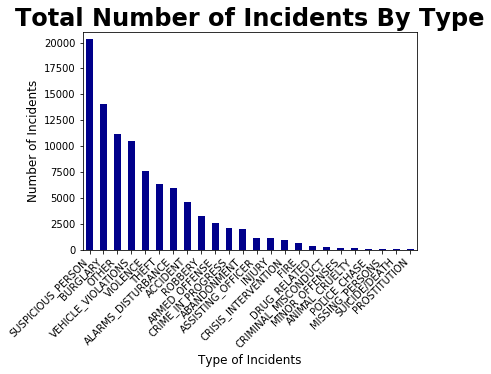

In [37]:
calls.plot(kind="bar", facecolor='darkblue')
plt.xticks(rotation=45, ha='right')
plt.title("Total Number of Incidents By Type", fontsize=24, fontweight='bold')
plt.ylabel("Number of Incidents", fontsize=12)
plt.xlabel("Type of Incidents", fontsize=12)
plt.rcParams["figure.figsize"] = (23,8)
plt.ylim(0, 21000)
plt.show()

# Analysis of Figure 2. 

We looked at what was being reported as incidents throughout the city. We originally started with 500 different incident report types. We sifted through and grouped them together into twenty-four different categories. When originally discussing our hypothesis our team assumed more mainstream crimes (e.i. gunshots, drugs, traffic, murder..) were going to be the most listed. Suspicious persons reports lead to the number one incident report right now, following with burglary. I think it is alarming how prevalent burglary is within the such a large growing city. 

Additional area of exploration include: What percentage does each incident type make-up of the total amount of incidents? Does the type of incident dominance change depending on the watch itself? Is there a better way to sift through and sort what falls within the category "other?"



# How does time of day, day of the week and month of the year affect the frequency of crime?


In [38]:
#find out how many incidents occured within which watch (split between times of the day)
watch_count = police_df.groupby('Watch')['Incident Number w/year'].count()
watch_count

Watch
1    32613
2    28896
3    33931
Name: Incident Number w/year, dtype: int64

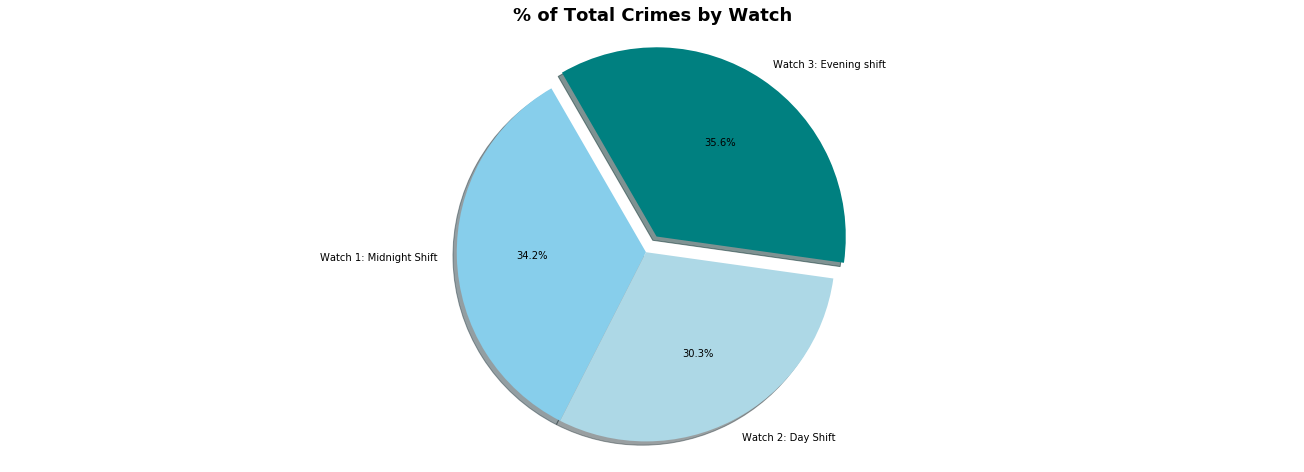

In [39]:
total_crimes_by_watch= police_df.groupby('Watch')['Incident Number w/year'].count()
type_labels = 'Watch 1: Midnight Shift', 'Watch 2: Day Shift', 'Watch 3: Evening shift'
colors = ['skyblue', 'lightblue', 'teal']
explode = [.0,.0,.1]
plt.pie(total_crimes_by_watch, labels= type_labels, colors= colors,
autopct='%1.1f%%', shadow=True, explode=explode, startangle=120)
plt.title('% of Total Crimes by Watch', fontsize = 18, fontweight='bold') 
plt.axis("equal")
plt.show()

## Analysis of Figure 4. 

Observations: We did a count to the number of incidents that occur within each watch over a one year time frame. Each watch is defined by: Midnight, Day, Evening. Evening shift has the highest amounts of incidents that occur within a year followed by the morning shift. Under initial hypothesis, our group thought that morning and night shift would be significantly different from the day shift. Particularly the night shift having the most action. Technically our hypothesis was not incorrect but there is a lot more additional questions that can be generated from the below graph. 

Additional areas of exploration could include: What type of incidents are most prevalent within each watch? Does the percentage change based on where the watches consider home base and do their patrols? Would data be the same if there were multiple year’s worth of data? 


In [40]:
#Preview of the dispatch time
police_df['Call Dispatch Date Time'].head()

205      8/4/2018 23:30
212    11/30/2018 08:53
219    11/18/2018 00:39
221    12/31/2018 15:20
222     9/21/2018 08:48
Name: Call Dispatch Date Time, dtype: object

In [41]:
#Parsed the dispatch_time to get the time of day only
dispatch_time_split = police_df['Call Dispatch Date Time'].str.split(expand=True)
dispatch_time = dispatch_time_split[1]
dispatch_time.head()

205    23:30
212    08:53
219    00:39
221    15:20
222    08:48
Name: 1, dtype: object

In [42]:
#Pulling the time that the incident occured (to compare the difference)
incident_time = police_df['Time1 of Occurrence']
incident_time.head()

205    21:54
212    15:20
219    00:25
221    14:00
222    08:48
Name: Time1 of Occurrence, dtype: object

In [43]:
#Converting both times into leteral quantitative time 
dispatch_time_conversion = [datetime.strptime(x, '%H:%M') for x in dispatch_time]
incident_time_conversion = [datetime.strptime(x, '%H:%M') for x in incident_time]

#convert all time to minutes for the purpose of deriving the difference.
dispatch_time_minutes = (pd.to_datetime(dispatch_time_conversion).hour * 60) + (pd.to_datetime(dispatch_time_conversion).minute)
incident_time_minutes = (pd.to_datetime(incident_time_conversion).hour * 60) + (pd.to_datetime(incident_time_conversion).minute)

In [44]:
#Create a minutes_time_df that holds the dispatch_time_minutes and the incident_time_minutes
minutes_time_df = pd.DataFrame({"Dispatch": dispatch_time_minutes, 
                            "Incident": incident_time_minutes})
minutes_time_df.head()

,Dispatch,Incident
0,1410,1314
1,533,920
2,39,25
3,920,840
4,528,528


In [45]:
#make a response_time_minutes using the minutes_time_df 
response_time_minutes = minutes_time_df['Dispatch'] - minutes_time_df['Incident']
response_time_minutes.head()

0     96
1   -387
2     14
3     80
4      0
dtype: int64

In [46]:
#Add the dispatch_time_minutes, incident_time_minutes and response_time_minutes to the police_df
police_df['Time_of_Dispatch'] = dispatch_time_minutes
police_df['Time_of_Incident'] = incident_time_minutes
police_df['Response_Time'] = response_time_minutes

In [47]:
police_df.head()

,Incident Number w/year,Year of Incident,Watch,Call (911) Problem,Type of Incident,Date1 of Occurrence,Month1 of Occurence,Day1 of the Week,Time1 of Occurrence,Call Dispatch Date Time,X Coordinate,Y Cordinate,Zip Code,City,State,Time_of_Dispatch,Time_of_Incident,Response_Time
205,171565-2018,2018,3,OTHER,VIO PROTECT ORDER BIAS/PREJUDICE,8/4/2018,August,Sat,21:54,8/4/2018 23:30,2476498.585,6971715.153,75212.0,DALLAS,TX,1410,1314,64.0
212,257226-2018,2018,2,SUSPICIOUS_PERSON,ABANDONED PROPERTY (NO OFFENSE),11/26/2018,November,Mon,15:20,11/30/2018 08:53,2548241.858,6932130.126,75253.0,DALLAS,TX,533,920,11.0
219,249258-2018,2018,1,ACCIDENT,PUBLIC INTOXICATION,11/18/2018,November,Sun,00:25,11/18/2018 00:39,2525365.155,6960102.895,75217.0,DALLAS,TX,39,25,156.0
221,279186-2018,2018,2,INJURY,ASSAULT -BODILY INJURY ONLY,12/31/2018,December,Mon,14:00,12/31/2018 15:20,2496126.907,6941940.628,75216.0,DALLAS,TX,920,840,-1.0
222,209518-2018,2018,2,VEHICLE_VIOLATIONS,WARRANT-DALLAS PD (ALIAS/CAPIAS),9/21/2018,September,Fri,08:48,9/21/2018 08:48,2487800.730,6937829.316,75216.0,DALLAS,TX,528,528,0.0


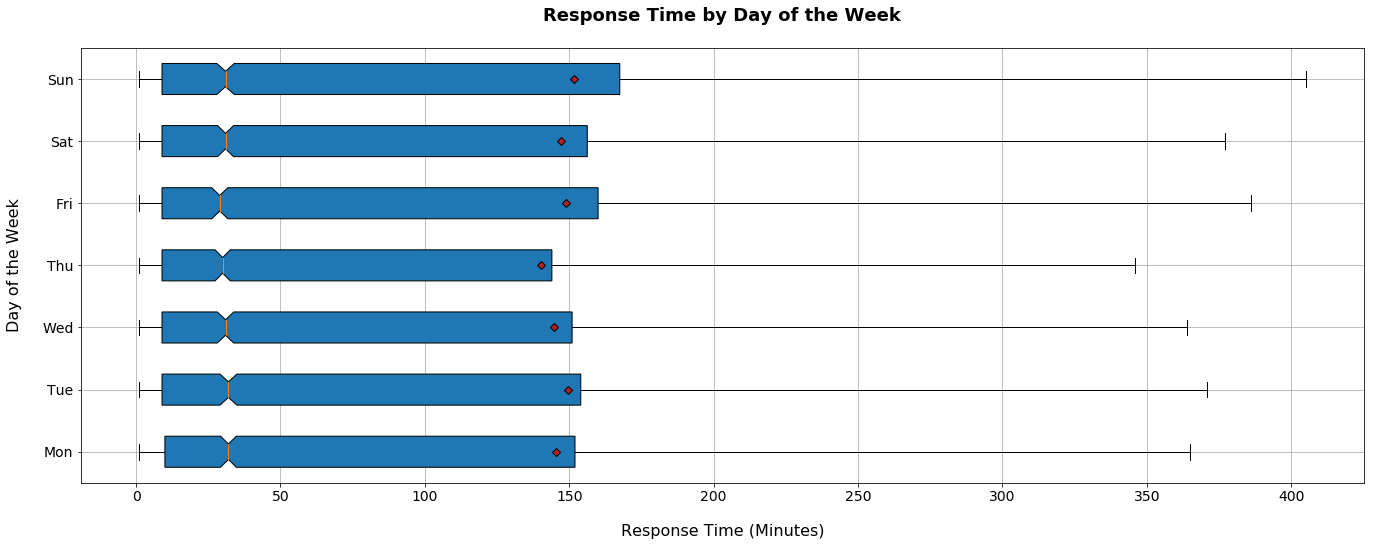

In [48]:
# Create dataframe for positive response time only
police_df_posi = police_df.loc[police_df["Response_Time"] > 0, :]

# Create x_axis for day of week, shown in order
police_df_posi["Day1 of the Week"].unique()
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

dispatch = []
for day in days:
    dispatch.append(police_df_posi[police_df_posi["Day1 of the Week"] == day]["Response_Time"].values)

# Plot and format figure
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

plt.boxplot(dispatch, labels= days, showfliers=False, patch_artist=True, showmeans=True, meanprops=meanpointprops, notch=True, vert=0)
plt.title("Response Time by Day of the Week"
          "\n", fontsize=18, fontweight='bold')
plt.xlabel("Response Time (Minutes)", fontsize=16, labelpad=20)
plt.ylabel("Day of the Week", fontsize=16, labelpad=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.autolayout : True

plt.grid()
plt.show()



# Analysis of Figure 5. 

Analysis: To look at dispatch time for call received, this box and whisker plot summaries key statistics as well as dispersion of our data. On question our team constantly found ourselves circling around what does the time of day/week/month have any effect on crime response and priority. The data shows that there is large variability of the response time for calls received, represented by the long whiskers. Interquartile range (i.e. 25% and 75% percentile difference) is about 146 minutes, and the maximum can go as long as more than 400 minutes. The data is skewed to the right, with 50% of all calls responded around 31 minutes, but a lot of the longer ones skewed the mean time to around 140 minutes. Seen from the maximum and 75% percentile, Sunday has the longest respond time and Thursday has the shortest. 

Additional Areas of Exploration could include: what does the average work force look like scattered throughout the week? Are less people in the office on Sunday and therefore causing the blockage? What are root causes on why response time is so delayed? If multiple people call into the same crime does it increase the priority of a report?

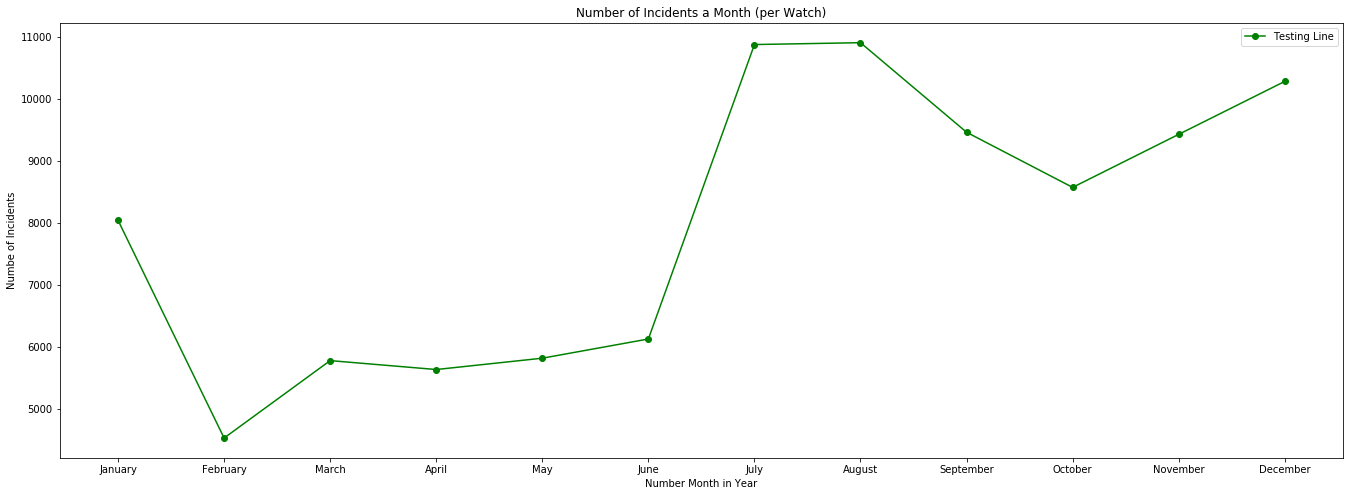

In [49]:
month_count = police_df.groupby('Month1 of Occurence')['Incident Number w/year'].count()
month_count
month_count_df = pd.DataFrame(month_count)
month_count_df.insert(1, "Indexcol", [4,8,12,2,1,7,6,3,5,11,10,9], True)
month_count_df.reset_index(inplace=True)
month_count_df.sort_values("Indexcol", ascending=True, inplace=True)

tester_line, = plt.plot(month_count_df["Month1 of Occurence"], month_count_df["Incident Number w/year"], color='green', label='Testing Line', marker="o")
plt.title('Number of Incidents a Month (per Watch)')
plt.xlabel('Number Month in Year')
plt.ylabel('Numbe of Incidents')

plt.legend(handles= [tester_line], loc='best')
plt.show()



# Analysis of Figure 6. 


Analysis: When initially having discussions around different questions and hypothesis there was the ongoing theory that summer time is the highest crime rate of the year due to the heat causing agitation. It was interesting to see that July, August, and December are actually the highest reported monthly incidents. Our hypothesis was supported with July and August having the highest number ove incidents reported, but also looking at the upward trend that moves upward rapidly and holds around June to December. 


Additional Areas of Exploration include: What would a three year line graph look like in comparison? Does the line graph and the increase/decrease in incidents relate to human holidays or weather? Are different incidents more prevalent in certain months?
